<a id='Содержание'>Содержание</a>

1. [Парсинг](#Парсинг)
2. [Распределения](#Распределения)
3. [Рейтинг](#Рейтинг)
4. [Карта](#Карта)

In [ ]:
from selenium import webdriver 
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
import selenium.webdriver.support.ui as UI
import selenium.webdriver.support.expected_conditions as EC 
from selenium.webdriver.common.by import By

from lxml import html

import time

import pandas as pd
import numpy as np
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors

import gmaps
import gmaps.geojson_geometries

<a id='Парсинг'>Парсинг</a>
<br></br>
[Наверх](#Содержание)

In [ ]:
'''
Эти функции мы запихнем в map, чтобы убрать символы валют из всех элементов списка цен.
'''

def remove_eur(s):
    return s[:-4]

def remove_usd(s):
    return s[1:]

def remove_rub(s):
    return s[:-2]

In [ ]:
'''
Очищаем строки цен от символов валюты, пересчитываем в рубли.
'''

def city_price(xp_prices):
    usd = 59.38
    eur = 67.38
    try:
        if xp_prices[0][0] == '$':
            xp_prices = map(remove_usd, xp_prices)
            xp_prices = list(map(lambda x: x.replace(' ', ''), xp_prices))
            xp_prices = np.array(xp_prices).astype(np.float)
            xp_prices = xp_prices * usd

        elif xp_prices[0][-1] == 'R':
            xp_prices = map(remove_eur, xp_prices)
            xp_prices = list(map(lambda x: x.replace(' ', ''), xp_prices))
            xp_prices = np.array(xp_prices).astype(np.float)
            xp_prices = xp_prices * eur

        else:
            xp_prices = map(remove_rub, xp_prices)
            xp_prices = list(map(lambda x: x.replace(' ', ''), xp_prices))
            xp_prices = np.array(xp_prices).astype(np.float)
                        
    except:
        xp_prices = [np.NaN]
        
    return xp_prices

In [ ]:
def avoid_popups(driver):
    # Обходим поп-апы.
    try:      
        driver.find_element_by_id('fancybox-close').click()
        time.sleep(15)
    except:
        pass
    try:      
        driver.find_element_by_class_name('webim_close').click()
        time.sleep(15)
    except:
        pass

In [ ]:
def setting_up_driver(url):
    driver = webdriver.Chrome(executable_path='/home/vanya/double_data/chromedriver')
    
    driver.get(url)

    # tez-tour не любит, когда диапазон дат для поиска тура больше 18 дней.
    driver.find_element_by_id('st-after').clear()
    driver.find_element_by_id('st-after').send_keys('15.07.2017')
    driver.find_element_by_id('st-before').clear()
    driver.find_element_by_id('st-before').send_keys('22.07.2017')

    # Делаем список опций для выпадающего списка стран.
    country_select = driver.find_element_by_id('countries')
    select = Select(country_select)
    options = select.options

    wait = UI.WebDriverWait(driver, 30)
    
    return select, options, wait, driver

In [ ]:
'''
Парсим tez-tour. В результате получим два списка: страны и средние цены на тур в рублях.
'''

# В этих двух списках будем хранить страны и средние цены.
ls_countries = []
ls_cities = []
ls_city_prices = []

url = 'https://www.tez-tour.com/search.html'

_, options, _, driver = setting_up_driver(url)

rng_options = len(options) - 1

driver.quit()

# Проходимся по списку опций стран.
for index in range(0, rng_options):
    select, options, wait, driver = setting_up_driver(url)
    # По Египту и Израилю можно выбрать опции из списка, но цены по ним не показывают, но остаются предыдущие
    # (от Доминиканы).
    if options[index].text not in ['Египет', 'Израиль']:
        select.select_by_index(index)
        
        # Обходим поп-апы.
        avoid_popups(driver)
        
        time.sleep(20)
        # Нажимаем на кнопку найти.      
        find_btn = wait.until(EC.element_to_be_clickable((By.XPATH, '//input[@class="gStatTourSearch"]')))
        find_btn.click()
        
        time.sleep(15)
        
        # Нажимаем на кнопку "Еще результаты" пока можно.        
        while True:
            try:
                # Обходим поп-апы.
                avoid_popups(driver)
            
                driver.find_element_by_id('moreresultsA').click()
                time.sleep(1)
            except Exception as e:
                print(e)
                break
                
        tree = html.fromstring(driver.page_source)
        # Собираем цены по одной стране в список.
        el_prices = tree.xpath('//td/h5/a[not(div)]/text()|//div[@class="cardprice"]/text()')
        # Усредняем, записываем страну и цену в список.
        ls_city_price = city_price(el_prices)
        country = options[index].text       
        # Собираем города по одной стране в список.
        el_cities = tree.xpath('//td[span and br]/span/text()')
        cities = el_cities
        ls_countries = [country] * len(cities)
        
        if len(cities) == 0:
            cities = [np.NaN]
            ls_countries = [np.NaN]
        
        # Записываем Датафрейм с ценами и городами для одной страны в файл.
        df = pd.DataFrame({'country': ls_countries, 'city': cities, 'city_prices': ls_city_price})
        df.to_csv('country_city_data.csv', mode='a', header=False)
                        
    else:
        continue

    driver.quit()

In [ ]:
'''
Читаем данные из файла. Чистим данные.
'''    
df_read = pd.read_csv('country_city_data.csv', header=None, names=['city', 'price', 'country'])
df_clean = df_read.dropna()

# Оказалось, что tez-tour кроме названий городов запихивает в список регионов еще и такие артефакты, как 
# "Экскурсионные туры - Вена".

all_cities = df_clean['city'].unique()
for city in all_cities:
    df_clean.loc[(df_clean['city'].str.contains(city + ' ') | 
                  df_clean['city'].str.contains(' ' + city)), 'city'] = city

df_clean['city'] = df_clean['city'].str.replace(' \d+', '')

<a id='Распределения'>Распределения</a>
<br></br>
[Наверх](#Содержание)

In [143]:
'''
Получим распределения поездок для всех стран и городов.
'''
# Функция для распределений. У всех пар страна-город будут распределния с одинаковыми интервалами цен.
# Сами интервалы имеют логарифмическую шкалу между min_price и max_price, значения меньше min_price и 
# больше max_price попадают в отдельные интервалы.
def make_hist(prices, min_price=50000, max_price=500000, num=8):

    all_hist = np.zeros(num + 1)
    all_hist[0] = np.sum(prices < min_price)
    all_hist[-1] = np.sum(prices > max_price)
    
    start_bin = np.log(min_price)
    stop_bin = np.log(max_price)
    bins = np.logspace(start=start_bin, stop=stop_bin, num=num, base=np.e)

    hist = np.histogram(prices, bins=bins)
    
    all_hist[1:num] = hist[0]    
    norm_hist = all_hist*1. / sum(all_hist)
    return norm_hist, np.insert(hist[1], 0, 0, axis=0)

all_countries = df_clean['country'].unique()

ls_hist_countries = []
ls_hist_cities = []
ls_hist = []
ls_bins = []
# Проходим по всем парам страна-город. Строим распределения.
for country in all_countries:
    for city in df_clean.loc[df_clean['country'] == country, 'city'].unique():
        prices = df_clean.loc[(df_clean['city'] == city) & (df_clean['country'] == country), 'price']
        hist, bins = make_hist(prices)
        ls_hist_countries.append(country)
        ls_hist_cities.append(city)
        ls_hist.append(hist)
        ls_bins.append(bins)

# Добавляем в отдельный дата-фрейм.
df_hist = pd.DataFrame({'country': ls_hist_countries, 'city': ls_hist_cities, 'hist': ls_hist, 'bins': ls_bins})
df_hist.head(10)

,bins,city,country,hist
0,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Вена,Австрия,"[0.00695397566109, 0.0922316771891, 0.16771891..."
1,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Баден,Австрия,"[0.0, 0.0287253141831, 0.38539796529, 0.444643..."
2,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Лаа-ан-дер-Тайя,Австрия,"[0.0, 0.0, 0.0698198198198, 0.407657657658, 0...."
3,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Лойперсдорф,Австрия,"[0.0, 0.0, 0.0, 0.262019230769, 0.550480769231..."
4,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Бад-Тацмансдорф,Австрия,"[0.0, 0.0, 0.0, 0.246978851964, 0.63670694864,..."
5,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Минск,Беларусь,"[0.984223300971, 0.0157766990291, 0.0, 0.0, 0...."
6,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Гродно,Беларусь,"[0.200731261426, 0.799268738574, 0.0, 0.0, 0.0..."
7,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Экскурсионные туры,Беларусь,"[0.756097560976, 0.243902439024, 0.0, 0.0, 0.0..."
8,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Св. Константин и Елена,Болгария,"[0.0285714285714, 0.412244897959, 0.5591836734..."
9,"[0.0, 50000.0, 69474.7747187, 96534.8864442, 1...",Золотые пески,Болгария,"[0.0323679727428, 0.427597955707, 0.5400340715..."


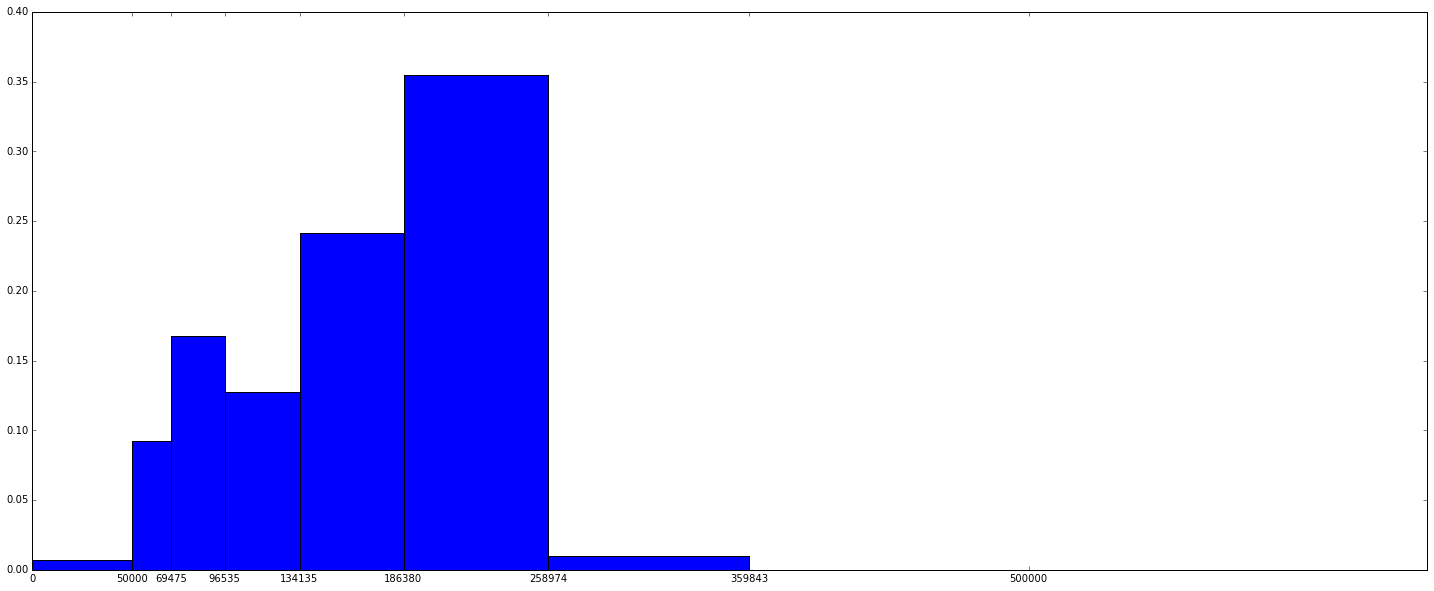

In [144]:
'''
Построим график распределения для Вены
'''
plot_bins = df_hist.loc[df_hist['city'] == 'Вена', 'bins'].item()
plot_bins = np.hstack([plot_bins, np.array(2*plot_bins[-1] - plot_bins[-2])])
n_hist = df_hist.loc[df_hist['city'] == 'Вена', 'hist'].item()

plt.figure(figsize = (25,10))
plt.bar(plot_bins[:-1], n_hist, width= 1. * (plot_bins[1:] - plot_bins[:-1]))
plt.xticks(plot_bins[:-1])
plt.show()

<a id='Рейтинг'>Рейтинг</a>
<br></br>
[Наверх](#Содержание)

In [145]:
'''
Рейтинг
'''
ls_rating_countries = []
ls_average_prices = []

for country in all_countries:
    ls_rating_countries.append(country)
    ls_average_prices.append(np.mean(df_clean.loc[df_clean['country'] == country, 'price']))
    
df_rating = pd.DataFrame({'country': ls_rating_countries, 'price': ls_average_prices})
df_rating_sorted = df_rating.sort_values(['price', 'country'], ascending=[True,False])
df_rating_sorted.index = range(1, len(df_rating_sorted) + 1)

df_rating_sorted.round(2)

,country,price
1,Беларусь,50080.78
2,Россия,52018.55
3,Чехия,59570.32
4,Кипр,61076.77
5,Литва,69948.67
6,Болгария,70557.90
7,Латвия,73498.16
8,Таиланд,75851.02
9,Греция,85897.24
10,Грузия,94127.50


<a id='Карта'>Тепловая карта</a>
<br></br>
[Наверх](#Содержание)

In [147]:
'''
Строим тепловую карту.
'''
with open("countries_rus.csv") as csv_codes:
    reader = csv.reader(csv_codes)
    codes_dict = {row[2]:row[1] for row in reader}
    
df_rating_sorted["country_eng"] = df_rating_sorted["country"].map(codes_dict)

# Я не стал показывать свой API key.
gmaps.configure(api_key="AI")

countries_geojson = gmaps.geojson_geometries.load_geometry('countries')

min_price = min(df_rating_sorted['price'])
max_price = max(df_rating_sorted['price'])
price_range = max_price - min_price

def calculate_color(price):
    # Нормируем цену.
    normalized_price = (price - min_price) / price_range
    # Большая цена - темнее цвет страны.
    inverse_price = 1.0 - normalized_price
    # Делаем цену цветом.
    mpl_color = matplotlib.cm.gnuplot(inverse_price)
    gmaps_color = matplotlib.colors.rgb2hex(mpl_color)

    return gmaps_color

# Получаем цвет для каждой страны.
colors = []
for feature in countries_geojson['features']:
    country_name = feature['properties']['name']
    try:
        price = df_rating_sorted.loc[df_rating_sorted['country_eng'] == country_name, 'price'].iloc[0]
        color = calculate_color(price)
    except IndexError:
        color = (0, 0, 0, 0.3)
    colors.append(color)
    
fig = gmaps.figure()
price_layer = gmaps.geojson_layer(countries_geojson, fill_color=colors, stroke_color=colors, fill_opacity=0.8)
fig.add_layer(price_layer)
fig

In [ ]:
'''
Без API key карта не появится, поэтому приложил картинку
'''

![alt text](map.png "Карта")